## Preliminaries

In [3]:
library(ape)
library(ggtree)
library(phangorn)
library(Quartet)
library(adephylo)
library(ggplot2)
library(reshape2)
library(tidyverse)
library(gridExtra)
library(ggh4x)

#### Path for results (change accordingly)

In [43]:
REF_TREE <- "dummy_tree.nwk"
RANK_RTIME <- "rank/results_for_ngenes/timing_rankc.txt"
DCJ_RTIME <- "dcj/results_for_ngenes_unimog/timing_dcj.txt"

#### Function to display RF and Quartet metrics

In [2]:
display_metrics <- function(tree, ref_tree) {
    splitStatuses <- SplitStatus(tree, ref_tree)
    quartetStatuses <- QuartetStatus(tree, ref_tree)
    # the least, the better (by distance)
    #print(paste("Robinson-Foulds: ", RawSymmetricDifference(splitStatuses, similarity = TRUE)))
    print(paste("RF (normalized)", RawSymmetricDifference(splitStatuses, similarity = TRUE) / splitStatuses[, 'N']))
    # the greater, the better (by similarity)
    print(paste("Quartet: ", SymmetricDifference(quartetStatuses, similarity = TRUE)))
}

## Plotting and comparison of trees

#### Loading reference tree

In [4]:
ref_tree <- read.tree(REF_TREE)

#### Comparing running times

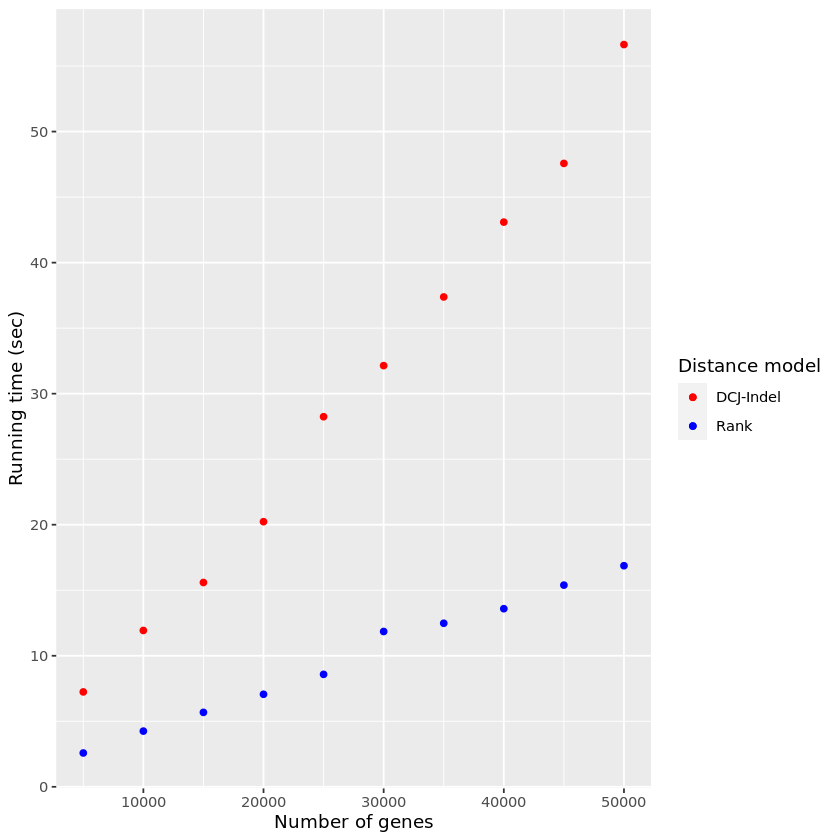

In [145]:
df_rank <- read.table(RANK_RTIME, col.names = c("rtime"))
df_rank$ngenes <- seq(from = 5000, by = 5000, to = 50000)

df_dcj <- read.table(DCJ_RTIME, col.names = c("rtime"))
df_dcj$ngenes <- seq(from = 5000, by = 5000, to = 50000)

png("rankc-vs-dcj_rtime.png")
ggplot() +
    geom_point(data = df_rank, mapping = aes(x = ngenes, y = rtime, color = "Rank")) +
    geom_point(data = df_dcj, mapping = aes(x = ngenes, y = rtime, color = "DCJ-Indel")) + 
    xlab("Number of genes") + ylab("Running time (sec)") +
    scale_color_manual(name = "Distance model", values = c("DCJ-Indel" = "red", "Rank" = "blue"))
dev.off()

#### Comparison as a function of *indel* rate

In [124]:
indels_rates <- c("0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9")

get_quartet_metrics <- function (path, dist, indel_rates, niters) {
    df <- setNames(data.frame(matrix(ncol = length(indels_rates), nrow = niters)), indels_rates)
    for (i in indels_rates) {
        quartets <- c()
        for (j in 1:niters) {
            tree <- read.tree(paste(path, dist, "_tree_indel-", i, "_iter", j, ".nwk", sep=""))
            quartetStatuses <- QuartetStatus(tree, ref_tree)
            quartet <- SymmetricDifference(quartetStatuses, similarity = TRUE)
            quartets <- c(quartets, quartet)
        }
        df[i] <- quartets
    }
    df
}
get_rf_metrics <- function (path, dist, indel_rates, niters) {
    df <- setNames(data.frame(matrix(ncol = length(indels_rates), nrow = niters)), indels_rates)
    for (i in indels_rates) {
        rfs <- c()
        for (j in 1:niters) {
            tree <- read.tree(paste(path, dist, "_tree_indel-", i, "_iter", j, ".nwk", sep=""))
            splitStatuses <- SplitStatus(tree, ref_tree)
            rf <- RawSymmetricDifference(splitStatuses, similarity = TRUE) / splitStatuses[, 'N']
            rfs <- c(rfs, rf)
        }
        df[i] <- rfs
    }
    df
}

In [147]:
rank <- get_quartet_metrics("rank/results_for_indel-rate/", "rankc", indel_rates, 10) %>%
    pivot_longer(everything()) %>%
    rename(irate = name, quartet = value)
rank$dist <- "Rank"
dcj <- get_quartet_metrics("dcj/results_for_indel-rate_unimog/", "dcj", indel_rates, 10) %>%
    pivot_longer(everything()) %>%
    rename(irate = name, quartet = value)
dcj$dist <- "DCJ-Indel"

df <- rbind(rank, dcj)

png("rank-vs-dcj_quartet.png")
ggplot(data = df, mapping = aes(x = irate, y = quartet, fill = dist)) + 
    geom_boxplot() +
    xlab("Indel rate") +
    ylab("Quartet") +
    scale_fill_discrete(name = "Distance model")
dev.off()

png 
  2

In [146]:
rank <- get_rf_metrics("rank/results_for_indel-rate/", "rankc", indel_rates, 10) %>%
    pivot_longer(everything()) %>%
    rename(irate = name, rf = value)
rank$dist <- "Rank"
dcj <- get_rf_metrics("dcj/results_for_indel-rate_unimog/", "dcj", indel_rates, 10) %>%
    pivot_longer(everything()) %>%
    rename(irate = name, rf = value)
dcj$dist <- "DCJ-Indel"

df <- rbind(rank, dcj)

png("rank-vs-dcj_rf.png")
ggplot(data = df, mapping = aes(x = irate, y = rf, fill = dist)) + 
    geom_boxplot() +
    xlab("Indel rate") +
    ylab("RF") +
    scale_fill_discrete(name = "Distance model")
dev.off()

png 
  2

#### Combinatios of simulator parameters

In [ ]:
confs <- c("GXIEz","GXIez","GXiEz","GXiez",
           "GxIEz","GxIez","GxiEz","Gxiez",
           "gXIEz","gXIez","gXiEz","gXiez",
           "gxIEz","gxIez","gxiEz","gxiez",
           "GXIEZ","GXIeZ","GXiEZ","GXieZ",
           "GxIEZ","GxIeZ","GxiEZ","GxieZ",
           "gXIEZ","gXIeZ","gXiEZ","gXieZ",
           "gxIEZ","gxIeZ","gxiEZ","gxieZ")

#### Functions to load metrics in dataframe

In [ ]:
get_quartet_metrics <- function (confs, dist, niters) {
    df <- setNames(data.frame(matrix(ncol = length(confs), nrow = 10)), confs)
    for (conf in confs) {
        quartets <- c()
        for (i in 1:niters) {
            tree <- read.tree(paste(dist, "/", dist, "_tree_", conf, "_iter", i, ".nwk", sep=""))
            quartetStatuses <- QuartetStatus(tree, ref_tree)
            quartet <- SymmetricDifference(quartetStatuses, similarity = TRUE)
            quartets <- c(quartets, quartet)
        }
        df[conf] <- quartets
    }
    df
}

get_rf_metrics <- function (confs, dist, niters) {
    df <- setNames(data.frame(matrix(ncol = length(confs), nrow = 10)), confs)
    for (conf in confs) {
        rfs <- c()
        for (i in 1:niters) {
            tree <- read.tree(paste(dist, "/", dist, "_tree_", conf, "_iter", i, ".nwk", sep=""))
            splitStatuses <- SplitStatus(tree, ref_tree)
            rf <- RawSymmetricDifference(splitStatuses, similarity = TRUE) / splitStatuses[, 'N']
            rfs <- c(rfs, rf)
        }
        df[conf] <- rfs
    }
    df
}

#### Functions to plot metrics and combinatios of simulator parameters as a grid

In [ ]:
plot_quartet <- function (df) {
    df %>%
    pivot_longer(everything()) %>%
    rename(quartet = value) %>%
    separate(name, into = c("gx", "ie", "z"), sep = c(2,4)) %>%
    ggplot(aes(x = "", y = quartet)) + 
        geom_boxplot() +
        facet_nested(gx ~ z + ie, scales = "free") +
        theme(axis.ticks.x = element_blank(), axis.title.x = element_blank())
}

plot_rf <- function (df) {
    df %>%
    pivot_longer(everything()) %>%
    rename(RF = value) %>%
    separate(name, into = c("gx", "ie", "z"), sep = c(2,4)) %>%
    ggplot(aes(x = "", y = RF)) + 
        geom_boxplot() +
        facet_nested(gx ~ z + ie, scales = "free") +
        theme(axis.ticks.x = element_blank(), axis.title.x = element_blank())
}

#### Rank vs. Reference

In [ ]:
#png("ref-vs-rank_quartet.png")
get_quartet_metrics(confs, "rank", 10) %>%
    plot_quartet()
#dev.off()

In [ ]:
#png("ref-vs-rank_rf.png")
get_rf_metrics(confs, "rank", 10) %>%
    plot_rf()
#dev.off()

#### Rank-Indel vs. Reference

In [ ]:
## no need

#### DCJ-Indel vs. Reference

In [ ]:
#png("ref-vs-dcj_quartet.png")
get_quartet_metrics(confs, "dcj", 10) %>%
    plot_quartet()
#dev.off()

In [ ]:
#png("ref-vs-dcj_rf.png")
get_rf_metrics(confs, "dcj", 10) %>%
    plot_rf()
#dev.off()